# Train Conditional UNet2D on MNIST with VAE and CLIP

This notebook trains a conditional diffusion model on MNIST using:
- **Pretrained VAE** (AutoencoderKL from Stable Diffusion) to encode images to latents
- **CLIP text encoder** to encode digit captions
- **UNet2DConditionModel** with cross-attention for text conditioning
- **DDPM scheduler** for training and inference
- **Classifier-free guidance** for improved sampling

## Key Design Choices
- MNIST images (28x28, grayscale) are upscaled to 128x128 (reduced from 256), 3 channels, normalized to [-1,1] for VAE compatibility
- VAE encodes to 16x16x4 latents
- Only the UNet is trained; VAE and CLIP are frozen
- Training includes loss tracking with per-batch and per-epoch visualization

## Memory Optimizations for 8GB GPU
- **Batch size**: 16 (reduced from 128)
- **Image size**: 128x128 (reduced from 256x256)
- **Mixed precision**: Enabled (FP16)
- **UNet channels**: Reduced from (128, 256, 256) to (64, 128, 128)
- **Gradient checkpointing**: Can be enabled if needed
- **Cache clearing**: Periodic GPU cache clearing to prevent fragmentation
- **DataLoader**: num_workers=0, pin_memory=False for memory efficiency

## 1. Imports and Setup

## Memory Usage Tips

If you still encounter OOM errors, try these additional optimizations:

1. **Further reduce batch size**: Change `batch_size` to 8 or even 4
2. **Reduce image size**: Change `image_size` to 64 (will train faster but lower quality)
3. **Enable gradient checkpointing** (uncomment in UNet creation if available)
4. **Close other applications** that might be using GPU memory
5. **Restart the kernel** to clear any lingering memory allocations

Current settings should work on most 8GB GPUs with CUDA.

In [1]:
from __future__ import annotations

import os
import math
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusers import DDPMScheduler
from diffusers.models import AutoencoderKL
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel

from transformers import CLIPTextModel, CLIPTokenizer

c:\Users\Shlomi\Desktop\Projects\final_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Helper Functions

In [2]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_transforms(image_size: int = 256) -> transforms.Compose:
    """Transform MNIST to 3x256x256 in [-1,1] for VAE."""
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )


def seed_everything(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## 3. Configuration

In [ ]:
@dataclass
class TrainConfig:
    dataset_root: str
    output_dir: str = "./outputs/train8"
    batch_size: int = 64
    num_epochs: int = 1
    lr: float = 1e-4
    num_train_timesteps: int = 1000
    image_size: int = 256
    tokenizer_max_length: int = 16
    cfg_dropout_p: float = 0.1  # classifier-free guidance dropout during training
    seed: int = 42
    mixed_precision: bool = False
    checkpoint_interval: int = 2000  # Save checkpoint every N steps
    # UNet size: we keep it small for MNIST
    unet_block_out_channels: tuple[int, ...] = (128, 256, 256)
    layers_per_block: int = 2


# Configure training parameters - OPTIMIZED FOR 8GB GPU
config = TrainConfig(
    dataset_root="../../datasets",
    output_dir="./outputs/train8",
    batch_size=16,  # Reduced from 128 to 16 for 8GB GPU
    num_epochs=5,
    lr=1e-4,
    image_size=128,  # Reduced from 256 to 128 to save memory
    mixed_precision=True,  # Enable mixed precision to save memory
    checkpoint_interval=2000,  # Save checkpoint every 2000 steps
)

print(f"Device: {get_device()}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.num_epochs}")
print(f"Learning rate: {config.lr}")
print(f"Image size: {config.image_size}")
print(f"Output directory: {config.output_dir}")
print(f"Mixed precision: {config.mixed_precision}")
print(f"Checkpoint interval: {config.checkpoint_interval} steps")

Device: cuda
Batch size: 16
Epochs: 5
Learning rate: 0.0001
Image size: 128
Output directory: ./outputs/train8
Mixed precision: True


## 4. Load Models

In [4]:
def create_models(device: torch.device, config: TrainConfig):
    # Pretrained VAE and CLIP text encoder/tokenizer
    print("Loading pretrained VAE...")
    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
    vae.requires_grad_(False)
    vae.eval()
    vae.to(device)

    print("Loading CLIP text encoder...")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder.requires_grad_(False)
    text_encoder.eval()
    text_encoder.to(device)

    print("Creating UNet2DConditionModel...")
    # Conditional UNet operating in latent space (4 channels)
    # Reduced size for memory efficiency on 8GB GPU
    unet = UNet2DConditionModel(
        sample_size=config.image_size // 8,  # 16 for 128x128
        in_channels=4,
        out_channels=4,
        layers_per_block=2,  # Reduced
        block_out_channels=(64, 128, 128),  # Reduced from (128, 256, 256)
        down_block_types=(
            "DownBlock2D",
            "CrossAttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "CrossAttnUpBlock2D",
            "UpBlock2D",
        ),
        cross_attention_dim=512,  # CLIP ViT-B/32 hidden size
    ).to(device)

    num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f"UNet trainable parameters: {num_params:,}")

    return vae, tokenizer, text_encoder, unet


# Initialize models
device = get_device()
seed_everything(config.seed)
vae, tokenizer, text_encoder, unet = create_models(device, config)

Loading pretrained VAE...
Loading CLIP text encoder...
Creating UNet2DConditionModel...
UNet trainable parameters: 8,844,164


## 5. Prepare Dataset

In [5]:
def make_dataloader(config: TrainConfig) -> DataLoader:
    tfms = build_transforms(config.image_size)
    ds = datasets.MNIST(root=config.dataset_root, train=True, download=True, transform=tfms)
    # Reduced num_workers and disabled pin_memory for better memory management
    return DataLoader(ds, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=False)


# Create dataloader
dataloader = make_dataloader(config)
print(f"Dataset size: {len(dataloader.dataset)}")
print(f"Number of batches: {len(dataloader)}")

Dataset size: 60000
Number of batches: 3750


## 6. Visualize Sample Data

Batch shape: torch.Size([16, 3, 128, 128])
Labels: [9, 1, 9, 1, 4, 0, 7, 7, 6, 4, 1, 1, 8, 3, 2, 5]


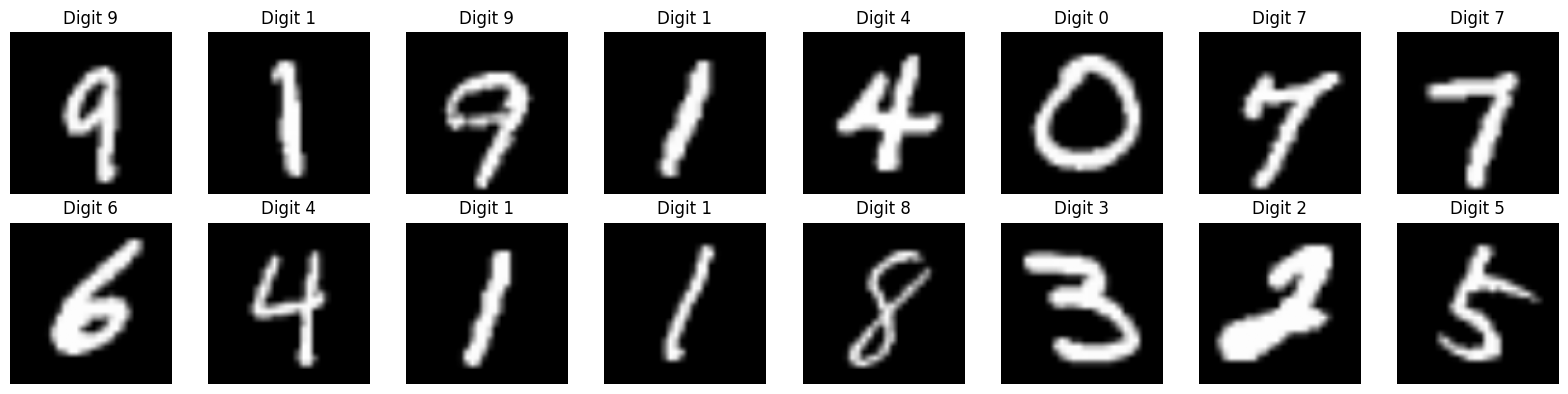

In [6]:
# Visualize a batch
sample_images, sample_labels = next(iter(dataloader))
print(f"Batch shape: {sample_images.shape}")
print(f"Labels: {sample_labels[:16].tolist()}")

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        img = sample_images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
        ax.imshow(img)
        ax.set_title(f"Digit {sample_labels[i].item()}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## 8. Training Loop

## 7. Checkpoint Management Functions

In [ ]:
def find_latest_checkpoint(output_dir: str):
    """Find the latest checkpoint in the output directory."""
    if not os.path.exists(output_dir):
        return None
    
    # Look for checkpoint files
    checkpoint_files = []
    for filename in os.listdir(output_dir):
        if filename.endswith('.pt') and (filename.startswith('unet_step_') or filename.startswith('unet_epoch_')):
            filepath = os.path.join(output_dir, filename)
            checkpoint_files.append(filepath)
    
    if not checkpoint_files:
        return None
    
    # Get the most recently modified checkpoint
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    return latest_checkpoint


def load_checkpoint(checkpoint_path: str, unet, optimizer=None):
    """Load checkpoint and return metadata."""
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict):
        if 'unet' in checkpoint:
            unet.load_state_dict(checkpoint['unet'])
        else:
            unet.load_state_dict(checkpoint)
        
        # Load optimizer state if available
        if optimizer is not None and 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        
        # Extract metadata
        metadata = {
            'global_step': checkpoint.get('global_step', checkpoint.get('step', 0)),
            'epoch': checkpoint.get('epoch', 0),
            'batch_losses': checkpoint.get('batch_losses', []),
            'epoch_losses': checkpoint.get('epoch_losses', []),
        }
    else:
        unet.load_state_dict(checkpoint)
        metadata = {'global_step': 0, 'epoch': 0, 'batch_losses': [], 'epoch_losses': []}
    
    print(f"Resumed from step {metadata['global_step']}, epoch {metadata['epoch']}")
    return metadata


def save_checkpoint(path: str, unet, optimizer, global_step: int, epoch: int, 
                   batch_losses: List[float], epoch_losses: List[float]):
    """Save checkpoint with complete metadata."""
    checkpoint = {
        'unet': unet.state_dict(),
        'optimizer': optimizer.state_dict(),
        'global_step': global_step,
        'epoch': epoch,
        'batch_losses': batch_losses,
        'epoch_losses': epoch_losses,
    }
    torch.save(checkpoint, path)


# Check for existing checkpoints
latest_checkpoint = find_latest_checkpoint(config.output_dir)
if latest_checkpoint:
    print(f"Found existing checkpoint: {latest_checkpoint}")
    print("Training will resume from this checkpoint.")
else:
    print("No existing checkpoints found. Starting training from scratch.")

### Checkpoint System Features

The checkpoint system provides:

1. **Automatic Resume**: Detects and loads the latest checkpoint automatically
2. **Complete Metadata**: Each checkpoint stores:
   - UNet model weights
   - Optimizer state (for proper resume)
   - Global step count
   - Current epoch number
   - Complete batch loss history
   - Complete epoch loss history
3. **Training Plots**: Loss plots saved with every checkpoint
4. **Multiple Checkpoint Types**:
   - Step checkpoints: `unet_step_2000.pt` (every 2000 steps)
   - Epoch checkpoints: `unet_epoch_1.pt` (after each epoch)
   - Final checkpoint: `unet_final.pt` (at completion)

If training is interrupted, simply re-run the training cell and it will automatically resume from the latest checkpoint!

In [ ]:
def train(config: TrainConfig, vae, tokenizer, text_encoder, unet, dataloader, device, resume_from_checkpoint: str = None):
    os.makedirs(config.output_dir, exist_ok=True)

    # Noise scheduler for training
    noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps, beta_schedule="squaredcos_cap_v2")

    optimizer = torch.optim.AdamW(unet.parameters(), lr=config.lr)
    scaler = torch.cuda.amp.GradScaler(enabled=config.mixed_precision and device.type == "cuda")

    # Loss tracking and training state
    batch_losses = []
    epoch_losses = []
    global_step = 0
    start_epoch = 0
    
    # Resume from checkpoint if available
    if resume_from_checkpoint:
        metadata = load_checkpoint(resume_from_checkpoint, unet, optimizer)
        global_step = metadata['global_step']
        start_epoch = metadata['epoch']
        batch_losses = metadata['batch_losses']
        epoch_losses = metadata['epoch_losses']
        print(f"Resuming training from step {global_step}, epoch {start_epoch}")

    unet.train()
    
    for epoch in range(start_epoch, config.num_epochs):
        epoch_loss_sum = 0.0
        epoch_batch_count = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}")
        
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device, non_blocking=True)

            # Create text captions from labels
            captions: List[str] = [f"A handwritten digit {int(l)}" for l in labels]

            # Tokenize (with classifier-free guidance dropout during training)
            if np.random.rand() < config.cfg_dropout_p:
                captions_input = [""] * len(captions)
            else:
                captions_input = captions

            text_inputs = tokenizer(
                captions_input,
                padding="max_length",
                max_length=config.tokenizer_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

            with torch.no_grad():
                # Encode images to latents using frozen VAE
                latents = vae.encode(images).latent_dist.sample() * 0.18215
                # Prepare text embeddings
                text_embeddings = text_encoder(text_inputs["input_ids"]).last_hidden_state

            # Sample noise and timestep; add noise
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Predict noise
            with torch.autocast(
                device_type=device.type,
                dtype=torch.float16 if (config.mixed_precision and device.type == "cuda") else torch.float32,
                enabled=config.mixed_precision
            ):
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
                loss = nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad(set_to_none=True)
            if scaler.is_enabled():
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            # Record loss
            loss_value = loss.item()
            batch_losses.append(loss_value)
            epoch_loss_sum += loss_value
            epoch_batch_count += 1

            global_step += 1
            pbar.set_postfix({"loss": f"{loss_value:.4f}", "step": global_step})

            # Clear cache every 50 batches to prevent fragmentation
            if batch_idx % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Save periodic checkpoints
            if global_step % config.checkpoint_interval == 0:
                ckpt_path = os.path.join(config.output_dir, f"unet_step_{global_step}.pt")
                save_checkpoint(ckpt_path, unet, optimizer, global_step, epoch, batch_losses, epoch_losses)
                print(f"\nCheckpoint saved: {ckpt_path}")
                
                # Save training plots with the checkpoint
                plot_path = os.path.join(config.output_dir, f"training_loss_step_{global_step}.png")
                save_loss_plot(batch_losses, epoch_losses, plot_path)
                print(f"Training plot saved: {plot_path}")

        # Record epoch average loss
        avg_epoch_loss = epoch_loss_sum / epoch_batch_count if epoch_batch_count > 0 else 0.0
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{config.num_epochs} - Average Loss: {avg_epoch_loss:.4f}")

        # Save per-epoch checkpoint
        ckpt_path = os.path.join(config.output_dir, f"unet_epoch_{epoch+1}.pt")
        save_checkpoint(ckpt_path, unet, optimizer, global_step, epoch + 1, batch_losses, epoch_losses)
        
        # Save training plots with epoch checkpoint
        plot_path = os.path.join(config.output_dir, f"training_loss_epoch_{epoch+1}.png")
        save_loss_plot(batch_losses, epoch_losses, plot_path)
        print(f"Training plot saved: {plot_path}")
        
        # Clear cache after each epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save final
    final_path = os.path.join(config.output_dir, "unet_final.pt")
    save_checkpoint(final_path, unet, optimizer, global_step, config.num_epochs, batch_losses, epoch_losses)
    print(f"\nFinal model saved: {final_path}")
    
    # Save final training plots
    final_plot_path = os.path.join(config.output_dir, "training_loss_final.png")
    save_loss_plot(batch_losses, epoch_losses, final_plot_path)
    print(f"Final training plot saved: {final_plot_path}")

    return batch_losses, epoch_losses


def save_loss_plot(batch_losses: List[float], epoch_losses: List[float], save_path: str):
    """Helper function to save loss plots without displaying them."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Per-batch loss
    if len(batch_losses) > 0:
        axes[0].plot(batch_losses, linewidth=0.8, alpha=0.7)
        axes[0].set_xlabel("Batch")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training Loss per Batch")
        axes[0].grid(True, alpha=0.3)

    # Per-epoch loss
    if len(epoch_losses) > 0:
        axes[1].plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linewidth=2)
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Average Loss")
        axes[1].set_title("Training Loss per Epoch")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close(fig)  # Close the figure to free memory

## 9. Run Training

## 8.5. Memory Optimization (Clear GPU Cache)

In [8]:
# Clear GPU cache before training to maximize available memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    # Set memory allocation configuration for better fragmentation handling
    import os
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Print current memory status
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU Memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print("Memory cache cleared and optimized for training")

GPU Memory allocated: 0.59 GB
GPU Memory reserved: 0.62 GB
Memory cache cleared and optimized for training


In [9]:
# Check for existing checkpoints and resume if available
latest_checkpoint = find_latest_checkpoint(config.output_dir)

# Train the model (will resume from checkpoint if found)
batch_losses, epoch_losses = train(
    config, vae, tokenizer, text_encoder, unet, dataloader, device, 
    resume_from_checkpoint=latest_checkpoint
)

C:\Users\Shlomi\AppData\Local\Temp\ipykernel_20964\3620777720.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=config.mixed_precision and device.type == "cuda")
Epoch 1/5:  13%|█▎        | 501/3750 [01:07<08:10,  6.62it/s, loss=0.1147, step=501]


Checkpoint saved: ./outputs/train8\unet_step_500.pt


Epoch 1/5:  27%|██▋       | 1001/3750 [02:14<06:55,  6.62it/s, loss=0.1725, step=1001]


Checkpoint saved: ./outputs/train8\unet_step_1000.pt


Epoch 1/5:  40%|████      | 1501/3750 [03:21<05:51,  6.41it/s, loss=0.1043, step=1501]


Checkpoint saved: ./outputs/train8\unet_step_1500.pt


Epoch 1/5:  53%|█████▎    | 2001/3750 [04:27<04:22,  6.65it/s, loss=0.1626, step=2001]


Checkpoint saved: ./outputs/train8\unet_step_2000.pt


Epoch 1/5:  67%|██████▋   | 2501/3750 [05:33<03:08,  6.62it/s, loss=0.1494, step=2501]


Checkpoint saved: ./outputs/train8\unet_step_2500.pt


Epoch 1/5:  80%|████████  | 3001/3750 [06:39<01:52,  6.63it/s, loss=0.1725, step=3001]


Checkpoint saved: ./outputs/train8\unet_step_3000.pt


Epoch 1/5:  93%|█████████▎| 3501/3750 [07:47<00:38,  6.53it/s, loss=0.0897, step=3501]


Checkpoint saved: ./outputs/train8\unet_step_3500.pt


Epoch 1/5: 100%|██████████| 3750/3750 [08:20<00:00,  7.50it/s, loss=0.0761, step=3750]


Epoch 1/5 - Average Loss: 0.1442


Epoch 2/5:   7%|▋         | 251/3750 [00:33<09:32,  6.11it/s, loss=0.1675, step=4001]


Checkpoint saved: ./outputs/train8\unet_step_4000.pt


Epoch 2/5:  20%|██        | 751/3750 [01:40<07:37,  6.56it/s, loss=0.1527, step=4501]


Checkpoint saved: ./outputs/train8\unet_step_4500.pt


Epoch 2/5:  33%|███▎      | 1251/3750 [02:47<06:44,  6.18it/s, loss=0.1817, step=5001]


Checkpoint saved: ./outputs/train8\unet_step_5000.pt


Epoch 2/5:  47%|████▋     | 1751/3750 [03:56<05:10,  6.44it/s, loss=0.0859, step=5501]


Checkpoint saved: ./outputs/train8\unet_step_5500.pt


Epoch 2/5:  60%|██████    | 2251/3750 [05:03<03:50,  6.49it/s, loss=0.1118, step=6001]


Checkpoint saved: ./outputs/train8\unet_step_6000.pt


Epoch 2/5:  73%|███████▎  | 2751/3750 [06:08<02:30,  6.64it/s, loss=0.1114, step=6501]


Checkpoint saved: ./outputs/train8\unet_step_6500.pt


Epoch 2/5:  87%|████████▋ | 3251/3750 [07:15<01:15,  6.63it/s, loss=0.1573, step=7001]


Checkpoint saved: ./outputs/train8\unet_step_7000.pt


Epoch 2/5: 100%|██████████| 3750/3750 [08:20<00:00,  7.49it/s, loss=0.1171, step=7500]



Checkpoint saved: ./outputs/train8\unet_step_7500.pt
Epoch 2/5 - Average Loss: 0.1090


Epoch 3/5:  13%|█▎        | 501/3750 [01:06<08:09,  6.63it/s, loss=0.0883, step=8001]


Checkpoint saved: ./outputs/train8\unet_step_8000.pt


Epoch 3/5:  27%|██▋       | 1001/3750 [02:12<06:57,  6.58it/s, loss=0.1143, step=8501]


Checkpoint saved: ./outputs/train8\unet_step_8500.pt


Epoch 3/5:  40%|████      | 1501/3750 [03:18<05:36,  6.69it/s, loss=0.0918, step=9001]


Checkpoint saved: ./outputs/train8\unet_step_9000.pt


Epoch 3/5:  53%|█████▎    | 2001/3750 [04:24<04:26,  6.56it/s, loss=0.1311, step=9501]


Checkpoint saved: ./outputs/train8\unet_step_9500.pt


Epoch 3/5:  67%|██████▋   | 2501/3750 [05:31<03:07,  6.65it/s, loss=0.0707, step=1e+4]


Checkpoint saved: ./outputs/train8\unet_step_10000.pt


Epoch 3/5:  80%|████████  | 3001/3750 [06:37<01:52,  6.67it/s, loss=0.1176, step=10501]


Checkpoint saved: ./outputs/train8\unet_step_10500.pt


Epoch 3/5:  93%|█████████▎| 3501/3750 [07:43<00:37,  6.58it/s, loss=0.1165, step=11001]


Checkpoint saved: ./outputs/train8\unet_step_11000.pt


Epoch 3/5: 100%|██████████| 3750/3750 [08:17<00:00,  7.53it/s, loss=0.0517, step=11250]


Epoch 3/5 - Average Loss: 0.1015


Epoch 4/5:   7%|▋         | 251/3750 [00:33<08:52,  6.58it/s, loss=0.0822, step=11501]


Checkpoint saved: ./outputs/train8\unet_step_11500.pt


Epoch 4/5:  20%|██        | 751/3750 [01:39<07:29,  6.67it/s, loss=0.0823, step=12001]


Checkpoint saved: ./outputs/train8\unet_step_12000.pt


Epoch 4/5:  33%|███▎      | 1251/3750 [02:45<06:18,  6.60it/s, loss=0.0567, step=12501]


Checkpoint saved: ./outputs/train8\unet_step_12500.pt


Epoch 4/5:  47%|████▋     | 1751/3750 [03:52<05:01,  6.64it/s, loss=0.1425, step=13001]


Checkpoint saved: ./outputs/train8\unet_step_13000.pt


Epoch 4/5:  60%|██████    | 2251/3750 [04:58<03:45,  6.64it/s, loss=0.1175, step=13501]


Checkpoint saved: ./outputs/train8\unet_step_13500.pt


Epoch 4/5:  73%|███████▎  | 2751/3750 [06:09<02:37,  6.33it/s, loss=0.1417, step=14001]


Checkpoint saved: ./outputs/train8\unet_step_14000.pt


Epoch 4/5:  87%|████████▋ | 3251/3750 [07:18<01:19,  6.26it/s, loss=0.0519, step=14501]


Checkpoint saved: ./outputs/train8\unet_step_14500.pt


Epoch 4/5: 100%|██████████| 3750/3750 [08:27<00:00,  7.38it/s, loss=0.1001, step=15000]



Checkpoint saved: ./outputs/train8\unet_step_15000.pt
Epoch 4/5 - Average Loss: 0.0973


Epoch 5/5:  13%|█▎        | 501/3750 [01:09<08:35,  6.30it/s, loss=0.0540, step=15501]


Checkpoint saved: ./outputs/train8\unet_step_15500.pt


Epoch 5/5:  27%|██▋       | 1001/3750 [02:19<07:09,  6.40it/s, loss=0.0990, step=16001]


Checkpoint saved: ./outputs/train8\unet_step_16000.pt


Epoch 5/5:  40%|████      | 1501/3750 [03:28<05:53,  6.36it/s, loss=0.0976, step=16501]


Checkpoint saved: ./outputs/train8\unet_step_16500.pt


Epoch 5/5:  53%|█████▎    | 2001/3750 [04:37<04:38,  6.28it/s, loss=0.0972, step=17001]


Checkpoint saved: ./outputs/train8\unet_step_17000.pt


Epoch 5/5:  67%|██████▋   | 2501/3750 [05:51<03:29,  5.97it/s, loss=0.1531, step=17501]


Checkpoint saved: ./outputs/train8\unet_step_17500.pt


Epoch 5/5:  80%|████████  | 3001/3750 [07:07<02:08,  5.85it/s, loss=0.0783, step=18001]


Checkpoint saved: ./outputs/train8\unet_step_18000.pt


Epoch 5/5:  93%|█████████▎| 3501/3750 [08:22<00:42,  5.80it/s, loss=0.0707, step=18501]


Checkpoint saved: ./outputs/train8\unet_step_18500.pt


Epoch 5/5: 100%|██████████| 3750/3750 [09:01<00:00,  6.93it/s, loss=0.0857, step=18750]


Epoch 5/5 - Average Loss: 0.0935

Final model saved: ./outputs/train8\unet_final.pt


## 10. Visualize Training Loss

Loss plots saved to ./outputs/train8\training_loss.png


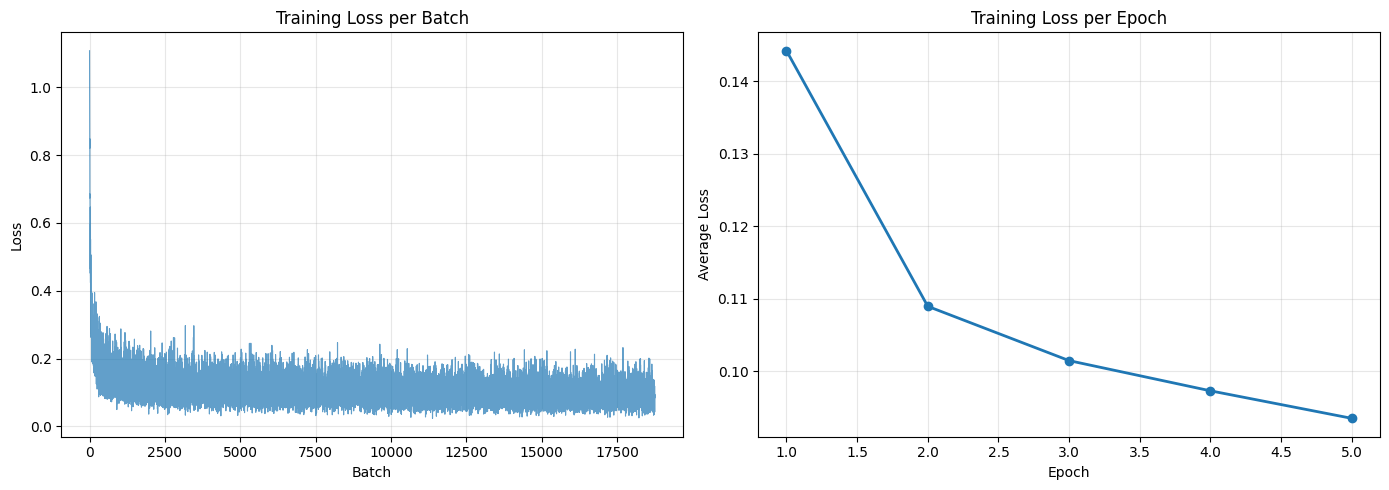

In [10]:
def plot_losses(batch_losses: List[float], epoch_losses: List[float], output_dir: str = None):
    """Generate and save loss plots for per-batch and per-epoch losses."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Per-batch loss
    axes[0].plot(batch_losses, linewidth=0.8, alpha=0.7)
    axes[0].set_xlabel("Batch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss per Batch")
    axes[0].grid(True, alpha=0.3)

    # Per-epoch loss
    if len(epoch_losses) > 0:
        axes[1].plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linewidth=2)
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Average Loss")
        axes[1].set_title("Training Loss per Epoch")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    
    if output_dir:
        loss_plot_path = os.path.join(output_dir, "training_loss.png")
        plt.savefig(loss_plot_path, dpi=150)
        print(f"Loss plots saved to {loss_plot_path}")
    
    plt.show()


# Plot the losses
plot_losses(batch_losses, epoch_losses, config.output_dir)

## 11. Sampling Function

In [11]:
@torch.no_grad()
def sample(
    prompt: str,
    guidance_scale: float = 7.5,
    num_inference_steps: int = 50,
    seed: Optional[int] = None,
):
    """Generate an image from a text prompt."""
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Get conditioned and unconditioned text embeddings for classifier-free guidance
    text_inputs = tokenizer(
        [prompt], padding="max_length", max_length=16, truncation=True, return_tensors="pt"
    ).to(device)
    text_embeddings = text_encoder(text_inputs.input_ids).last_hidden_state

    uncond_inputs = tokenizer([""], padding="max_length", max_length=16, return_tensors="pt").to(device)
    uncond_embeddings = text_encoder(uncond_inputs.input_ids).last_hidden_state

    encoder_hidden_states = torch.cat([uncond_embeddings, text_embeddings], dim=0)

    # Init random latents in latent space
    latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)

    unet.eval()
    for t in tqdm(scheduler.timesteps, desc="Sampling"):
        # Expand for classifier-free guidance
        latent_model_input = torch.cat([latents] * 2, dim=0)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=encoder_hidden_states).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Step
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = latents / 0.18215
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu()

    return image

## 12. Generate Samples

Generating: A handwritten digit 0


Sampling: 100%|██████████| 50/50 [00:01<00:00, 45.03it/s]


Generating: A handwritten digit 1


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.04it/s]


Generating: A handwritten digit 2


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.61it/s]


Generating: A handwritten digit 3


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.07it/s]


Generating: A handwritten digit 4


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.72it/s]


Generating: A handwritten digit 5


Sampling: 100%|██████████| 50/50 [00:01<00:00, 47.81it/s]


Generating: A handwritten digit 6


Sampling: 100%|██████████| 50/50 [00:01<00:00, 46.97it/s]


Generating: A handwritten digit 7


Sampling: 100%|██████████| 50/50 [00:01<00:00, 48.24it/s]


Generating: A handwritten digit 8


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.37it/s]


Generating: A handwritten digit 9


Sampling: 100%|██████████| 50/50 [00:00<00:00, 51.15it/s]


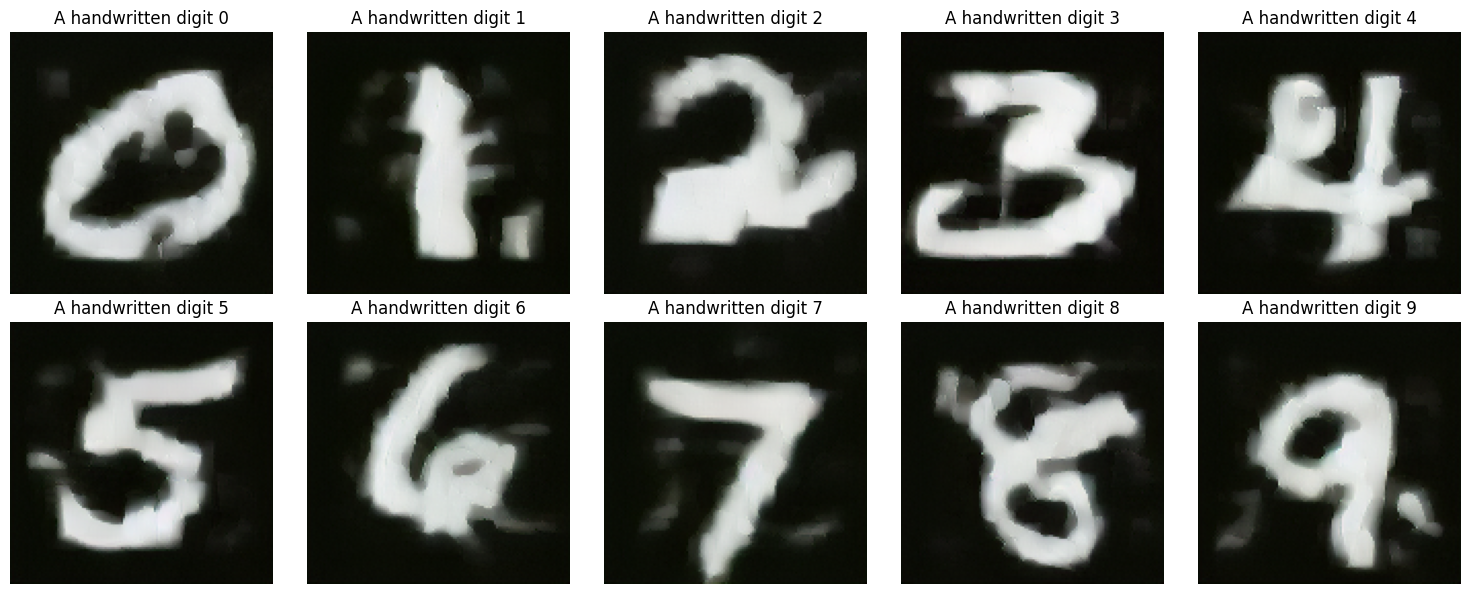

In [12]:
# Generate samples for different digits
prompts = [
    "A handwritten digit 0",
    "A handwritten digit 1",
    "A handwritten digit 2",
    "A handwritten digit 3",
    "A handwritten digit 4",
    "A handwritten digit 5",
    "A handwritten digit 6",
    "A handwritten digit 7",
    "A handwritten digit 8",
    "A handwritten digit 9",
]

guidance_scale = 7.5
num_inference_steps = 50

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (ax, prompt) in enumerate(zip(axes.flat, prompts)):
    print(f"Generating: {prompt}")
    generated_image = sample(
        prompt=prompt,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        seed=42 + i,
    )
    
    # Display image
    img = generated_image[0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(prompt)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, "generated_samples.png"), dpi=150)
plt.show()

## 13. Test Different Guidance Scales

Generating with guidance scale 0


Sampling: 100%|██████████| 50/50 [00:01<00:00, 47.51it/s]


Generating with guidance scale 3


Sampling: 100%|██████████| 50/50 [00:01<00:00, 47.01it/s]


Generating with guidance scale 5


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.95it/s]


Generating with guidance scale 7.5


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.36it/s]


Generating with guidance scale 10


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.27it/s]


Generating with guidance scale 15


Sampling: 100%|██████████| 50/50 [00:01<00:00, 49.36it/s]


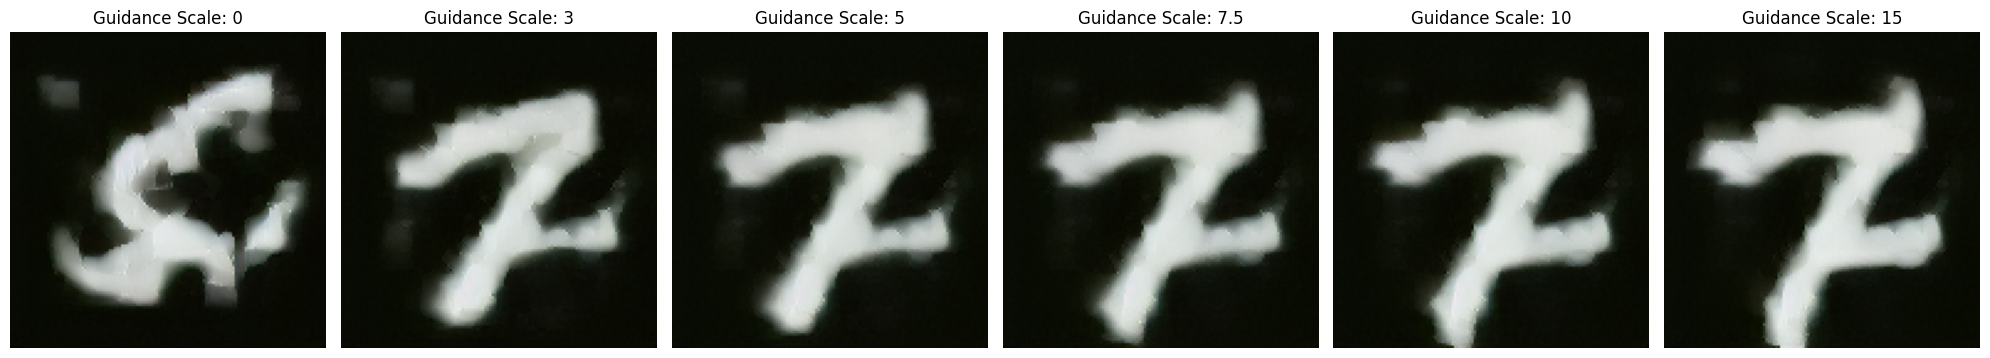

In [13]:
# Test different guidance scales for a single prompt
test_prompt = "A handwritten digit 7"
guidance_scales = [0, 3, 5, 7.5, 10, 15]

fig, axes = plt.subplots(1, len(guidance_scales), figsize=(20, 4))
for ax, gs in zip(axes, guidance_scales):
    print(f"Generating with guidance scale {gs}")
    generated_image = sample(
        prompt=test_prompt,
        guidance_scale=gs,
        num_inference_steps=50,
        seed=42,
    )
    
    img = generated_image[0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Guidance Scale: {gs}")
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, "guidance_scale_comparison.png"), dpi=150)
plt.show()

## 14. Save Individual Sample

Generating: A handwritten digit 3


Sampling: 100%|██████████| 50/50 [00:01<00:00, 48.17it/s]


Sample saved to: ./outputs/train8\sample_digit_3.png


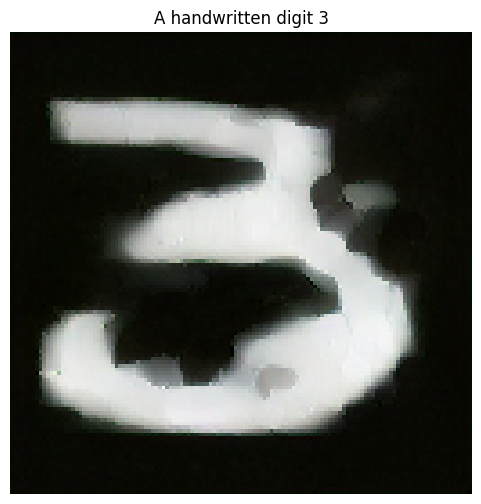

In [14]:
# Generate and save a single high-quality sample
from torchvision.utils import save_image

prompt = "A handwritten digit 3"
print(f"Generating: {prompt}")

generated_image = sample(
    prompt=prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    seed=42,
)

# Save to file
output_path = os.path.join(config.output_dir, "sample_digit_3.png")
save_image(generated_image, output_path)
print(f"Sample saved to: {output_path}")

# Display
plt.figure(figsize=(6, 6))
img = generated_image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(prompt)
plt.axis('off')
plt.show()